# Education Funding in the United States:
##       Using Budgetary Policy to address High School Graduation Rates


Public education is one of the most important long term investments that government makes in society, with universally recognized effects on public health, security, and happiness. As such, it is a large consumer of taxpayer dollars, and if federal, state, and local funding is combined, is competitive with the national defense budget. In 2016, US expenditures on primary and secondary education stood at $13,000 per student, 39% higher than the average among other developed countries (OECD members), and rangking 5th  overall out of 37.

However, this top line number obscures the complexity of the US educational funding. Since the bulk of school funding is from local property taxes, richer suburban communities often find themselves flush with cash, while their poorer, urban neighbors struggle to provided basic necessities. Resources are often concentrated where they are needed least, entrenching pre-existing societal divisions and limiting the freedom of opportunity for communities without access to quality education. 

In this project, we attempt to use deep learning to gain insights about the relationship between school funding and educational outcomes, here measured by high-school graduation rates. In particular, we will examine not only total funding amounts, but what revenue sources they draw from and how they are apportioned amongst instruction, support services, salaries, benefits, etc. If we can obtain a model with good performance we can investigate not only the affect of overall funding increases, but how to most effectively use the funding at hand to obtain a desired outcome.

One of the focusses of our analysis here is to capture the causal outcomes of policy changes, not just correlation. To do so, we perform a time-series analysis, training our neural network not only on funding data for the year in which the graduation rate data has been reported, but on the available history of educational funding up until that point. If a given policy intervention then leads to a change in graduation rate years later, the neural net should learn it.

Of course, the relationship between the raw funding numbers and graduation rates is not direct, and both are influenced by larger societal and economic factors. One of the main questions of this project then is exactly how determinitive funding is of educational outcomes: if our model has good performance we can reasonably expect that funding and recent academic outcomes are largely determinitive of graduation rate and then use our model to make informed decisions on budgetary policy. If it does not, then we we should calibrate our expectations accordingly on how much we expect to see direct results from only changes to funding policy.

What we find is that the model has excellent performance when predicting the current years graduation rate, with a mean-absolute-error (MAE). Unfortunately, when extrapolating farther into the future, performance degrades rapidly, with an MAE in excess of 10 points when projecting 5 years or further. We conclude that factors outside of strict budgetary policy become dominant the farther you zoom out. To create a more useful model for long term goal setting, we should take a more holistic approach. It would be interesting to include data on economics and demographics in our model, as well as other policy information not strictly related to finances in an attempt to improve performance.

Another thing that we have not done is examine how funding and graduation rate are distributed geographically throughout a given state. This would be a very interesting avenue of investigation due to the role that geographic differences in funding levels are believed to play in persistent inequality. The financial data for such an analysis is available since it is provided on a district by district basis, however, we were not able to find similarly geographically fine-grained data for graduation rates. It would be interesting to return to this question if this data becomes available, or if there is another educational or economic outcome we wish to investigate for which such data exists.


## The Data Sources

Educational funding data is taken from the National Center for Education Statistics (NCES) which provides year by year data on funding accross the country at the school district level. The data is extensive, covering over 18,000 educational agencies across the country from 1995 to 2017, with revenues and expenditures itemized into over 100 unique categories reflecting spending priorities. To summarize, the dataset includes

* Fall enrollment
* Revenues
    * Federal sources
    * State sources
    * Local sources
* Expenditures
    * Instruction
    * Support services
    * Administration
    * Operation and maintenence
    * Food and transportation services
    * Facilities acquizition and construction expenditures
    * Debt servicing

The target variable is the state-wide high school adjusted cohort graduation rate (ACGR), which measures the percentage of an incoming 9th grade class that graduates four years later. This is a useful and direct measure of eduactional outcome since it is a minimum requirement for continuing on to post-secondary education and indeed of obtaining higher paying jobs necessary for staying in the middle class. As a matter of principle, it is a measure of a high schools fulfilment of the minimum level of social service it is expected to provide. Data is taken from the National Information Center for Higher Education Policymaking and analysis and is available at the state-wide level from 1995 to 2017.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns
import plotly.express as px  # Be sure to import express

# formatting matplotlib graphics
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (16,16),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

from itertools import product # for iterating over multiple indices

# set visualization standards
figsize = (16,8)
sns.set(style="darkgrid", rc={'font.size':14,'axes.titlesize':25,'axes.labelsize':17,'xtick.labelsize':14,'ytick.labelsize':14})

# for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed

random_state = 0

# state/abbrev dictionaries
state_to_abbrev = {'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}
abbrev_to_state = dict(map(reversed, state_to_abbrev.items()))

# Data Preparation

We begin by loading all the financial data and converting it to 2021 dollars. The financial data comes at the district by district level, however, since we only have access to graduation rate at the state level, we will aggregate it to the state level to match.

In [2]:
# read all financial data
years = [str(x)+'-'+str(x+1) for x in range(1994,2017)]
files = [ '../input/us-school-district-finance-data-19902017/'+year+'.sas7bdat' for year in years]
dist_fin = [pd.read_sas(file) for file in files]

# fix an entry error on year
dist_fin[-1]['YEAR'] = dist_fin[-1]['YEAR'].replace(b'11',b'17')

# list of all the states for later use
states = list(dict.fromkeys(dist_fin[-1]['STABBR'].values))

# types of numeric columns we'll be interested in, we'll discard everything else except fall enrollment numbers
rev_cols = dist_fin[-1].iloc[:,18:70].columns.tolist() # revenues
exp_cols = dist_fin[-1].iloc[:,70:103].columns.tolist() # expenditures
other_fin_cols = dist_fin[-1].iloc[:,103:141].columns.tolist() + ['V95','V02','K14','CE1','CE2'] # salaries, benefits, debts, assets, etc.
fin_cols = rev_cols + exp_cols + other_fin_cols # all financial columns

# adjust for inflation to 2021 dollars
# rates from https://www.usinflationcalculator.com/
inf = [1.73,1.68,1.64,1.61,1.58,1.53,1.49,1.46,1.43,1.39,1.35,1.30,1.27,1.22,1.23,1.21,1.17,1.15,1.13,1.11,1.11,1.10,1.07]
for x in range(0,len(dist_fin)):
    cols = [col for col in fin_cols if col in dist_fin[x].columns]
    dist_fin[x][cols] = dist_fin[x][cols] * inf[x]
    
# make sure everything has common columns so can plug into common model
# intesect over columns for all years
common_cols = dist_fin[0].columns.tolist()
for x in range(1,len(dist_fin)):
    common_cols = [col for col in common_cols if col in dist_fin[1].columns.tolist()]

rev_cols = [col for col in rev_cols if col in common_cols]
exp_cols = [col for col in exp_cols if col in common_cols]
other_fin_cols = [col for col in other_fin_cols if col in common_cols]
fin_cols = [col for col in fin_cols if col in common_cols]



#------------------------------------------------------------------#
#------------------------------------------------------------------#
#------------------------------------------------------------------#
   
    

# aggregating to state level

# aggregate financial data to the state level
state_fin = [0]*len(dist_fin)
for x in range(len(state_fin)):
    cols = ['V33']+[col for col in fin_cols if col in dist_fin[x].columns]
    state_fin[x] = dist_fin[x].groupby('STABBR')[cols].sum()
    
# dataframes are indexed by state abbreviation in bytes, convert to string for later convenience
for x in range(len(state_fin)):
    state_fin[x].index = [st.decode('utf8') for st in state_fin[x].index.tolist()]
    
# put year in multi-index
for x in range(len(state_fin)):
    state_fin[x]['YEAR'] = 1995 + x
    state_fin[x] = state_fin[x].reset_index().rename(columns={'index':'STATE'})
    state_fin[x] = state_fin[x].set_index(['STATE','YEAR'])
    
    
# finally, we drop the data for Washington, DC since our data on the graduation rate does not cover DC
    
state_fin = [df.drop('DC',errors='ignore') for df in state_fin if 2016 >= df.index[0][1] >= 1995]

Let's take a quick look at what we have. In total we have 23 years of data. Each year is stored in a dataframe with 50 rows for each of the 50 states, and there are a 107 columns worth of financial data, plus fall enrollment, which is stored as `'V33'`. All data is numerical and there are no missing values.

In [3]:
print('Years of data:',len(state_fin))
print('Shape of dataframe:',state_fin[-1].shape)
state_fin[0].head()

Years of data: 22
Shape of dataframe: (50, 107)


,,V33,TOTALREV,TFEDREV,C14,C15,C16,C17,C19,B11,C20,...,V32,_19H,_21F,_31F,_41F,_61V,_66V,W01,W31,W61
STATE,YEAR,,,,,,,,,,,,,,,,,,,,,
AK,1995,125421.0,1.932528e+09,2.128540e+08,2.272182e+07,7989140.0,1942790.0,2290520.0,4318080.0,0.0,4965100.0,...,74390.0,7.481506e+08,179920000.0,151117230.0,7.782024e+08,0.0,0.0,0.0,0.000000e+00,0.000000e+00
AL,1995,727480.0,5.825666e+09,5.690956e+08,2.120011e+08,71971460.0,3925370.0,7695040.0,18678810.0,0.0,31963480.0,...,0.0,1.176166e+09,148683120.0,61781760.0,1.263076e+09,0.0,0.0,23740790.0,2.993281e+08,4.970100e+08
AR,1995,447757.0,3.559562e+09,3.417719e+08,1.309991e+08,32069010.0,2923700.0,4354410.0,11331500.0,0.0,27507000.0,...,0.0,1.358822e+09,112552070.0,74718700.0,1.402504e+09,25185340.0,55661020.0,20135470.0,1.945523e+08,3.337170e+08
AZ,1995,735018.0,6.600339e+09,6.512360e+08,1.769150e+08,46028380.0,4280020.0,7952810.0,20630250.0,6907890.0,73391790.0,...,0.0,5.057778e+09,790674010.0,340637000.0,5.507867e+09,0.0,0.0,369117990.0,1.084625e+09,6.806270e+08
CA,1995,5315832.0,5.105613e+10,4.519177e+09,1.337572e+09,500613560.0,30249050.0,50403550.0,100075310.0,0.0,707146150.0,...,0.0,3.447788e+09,874096340.0,130511200.0,4.191377e+09,0.0,0.0,0.0,6.228000e+07,1.301678e+10


What each column represents can be found in the documentation [here](https://nces.ed.gov/ccd/f33agency.asp). In our exploratory data analysis, we will just focus on a few of the most interesting ones. Before we continue, let's take some time out to prepare some more useful features. The numbers given the NCES are district (now aggregated to state)-wide funding totals, which may not be a good indicator since states are responsible for vastly different numbers of students. Below we replace the funding totals with with revenues and expenditures per puil by dividing by the total fall enrollment. For each of the itemized features, we also create a column for that feature as a percent of total revenue/expenditure depending on the type. This is a good indicator of the funding priorities of a state.

In [4]:
# preparing new features

# generate per pupil data for all financial data
for x in range(len(state_fin)):
    per_pupil = state_fin[x][fin_cols].div(state_fin[x]['V33'],axis=0)
    state_fin[x] = state_fin[x].join(per_pupil,rsuffix='_pupil')
    
# generate percent revenue data
for x in range(len(state_fin)):
    perc_rev = state_fin[x][rev_cols].div(state_fin[x]['TOTALREV'],axis=0)
    state_fin[x] = state_fin[x].join(perc_rev,rsuffix='_perc_rev').drop(columns=['TOTALREV_perc_rev'])
    
# generate percent expenditures data
for x in range(len(state_fin)):
    perc_exp = state_fin[x][exp_cols].div(state_fin[x]['TOTALEXP'],axis=0)
    state_fin[x] = state_fin[x].join(perc_exp,rsuffix='_perc_exp').drop(columns=['TOTALEXP_perc_exp'])
    
# drop everything that isn't suitably normalized, keep V33
cols_normalized = ['V33'] + [col for col in state_fin[0].columns.tolist() if (('_pupil' in col) or ('_perc' in col))]
for x in range(len(state_fin)):
    state_fin[x] = state_fin[x][cols_normalized]

After this there are 183 columns: the fall enrollment and 182 describing state finances that year on a per pupil basis.

In [5]:
print('Shape of dataframe:',state_fin[-1].shape)
state_fin[0].head()

Shape of dataframe: (50, 183)


,,V33,TOTALREV_pupil,TFEDREV_pupil,C14_pupil,C15_pupil,C16_pupil,C17_pupil,C19_pupil,B11_pupil,C20_pupil,...,TCAPOUT_perc_exp,F12_perc_exp,G15_perc_exp,K09_perc_exp,K10_perc_exp,K11_perc_exp,L12_perc_exp,M12_perc_exp,Q11_perc_exp,I86_perc_exp
STATE,YEAR,,,,,,,,,,,,,,,,,,,,,
AK,1995,125421.0,15408.325878,1697.116193,181.164398,63.698583,15.490149,18.262651,34.428684,0.00000,39.587469,...,0.132201,0.107896,0.008531,0.007640,0.008134,0.000000,0.00000,0.000000,0.000000,0.018352
AL,1995,727480.0,8008.008481,782.283513,291.418486,98.932562,5.395846,10.577665,25.676046,0.00000,43.937263,...,0.072573,0.051272,0.002006,0.009729,0.009567,0.000000,0.00000,0.000000,0.000000,0.012632
AR,1995,447757.0,7949.761813,763.297682,292.567308,71.621460,6.529658,9.724940,25.307254,0.00000,61.432875,...,0.074566,0.049356,0.003068,0.009384,0.012759,0.000000,0.00000,0.000000,0.010527,0.019763
AZ,1995,735018.0,8979.833487,886.013689,240.694772,62.622113,5.823014,10.819885,28.067680,9.39826,99.850330,...,0.175071,0.112226,0.014733,0.000000,0.000000,0.048112,0.00000,0.000000,0.008558,0.044743
CA,1995,5315832.0,9604.541720,850.135394,251.620441,94.174075,5.690370,9.481780,18.825898,0.00000,133.026429,...,0.088687,0.046389,0.009121,0.006221,0.005596,0.021361,0.00172,0.004031,0.006708,0.004056


Finally, let's add the state-wide adjusted cohort graduation rate (ACGR) to this as our target variable. There are some missing values that we have to take care of, most notably the year of 2007, for which there is no data available. We simply impute this as the average of the 2006 and 2008 data. There are then a handful of states with missing graduation rates, Idaho for 2010-2012 and Kentucky and Oklahoma for 2010-2011, which we again impute with averages of the two nearest years.

In [6]:
# load the graduation data, which is stored in tab delimited text files
state_grad = []
for x in range(1995,2017):
    # there is no data for 2007, will impute later
    if x == 2007:
        continue 
        
    # load the data
    year = str(x-1)[-2:] + '-'+ str(x)[-2:]
    filepath = '../input/state-4-year-cohort-high-school-graduation-rates/'+year+'.txt'
    df = pd.read_csv(filepath,delimiter = '\t').iloc[:,0].rename('grad_rate_'+str(x))
    
    # loaded data also contains 'Nation' grad rate, so remove so that all dataframes are same shape
    df = df.drop(['Nation'],errors='ignore')
    
    #formatting
    df = pd.DataFrame({'STATE':df.index.map(state_to_abbrev),
              'YEAR':[x]*50,
              'grad_rate':df.to_list()}).set_index(['STATE','YEAR'])
    
    # append to our year by year data list
    state_grad.append(df)
    
# impute the missing 2007 grad_rate as the average of the 2006 and 2008 data
grad_2006 = state_grad[11].copy()
grad_2006.index = grad_2006.index.map(lambda x : (x[0],x[1]+1))
grad_2008 = state_grad[12].copy()
grad_2008.index = grad_2008.index.map(lambda x : (x[0],x[1]-1))
state_grad.insert(12,(grad_2006+grad_2008)/2)

# we have null values in the grad_rates for 
# ID: 2010, 2011, 2012, KY: 2010, 2011, and OK: 2010, 2011
# for why, see footnote 3 of https://nces.ed.gov/ccd/tables/acgr_2010-11_to_2012-13.asp
# we will impute these with averages of the two closest years
state_grad[15].loc[('ID',2010)] = np.round((state_grad[18].loc[('ID',2013)] + state_grad[14].loc[('ID',2009)])/2)
state_grad[16].loc[('ID',2011)] = state_grad[15].loc[('ID',2010)]
state_grad[17].loc[('ID',2012)] = state_grad[15].loc[('ID',2010)]

state_grad[15].loc[('KY',2010)] = np.round((float(state_grad[17].loc[('KY',2012)]) + state_grad[14].loc[('KY',2009)])/2)
state_grad[16].loc[('KY',2011)] = state_grad[15].loc[('KY',2010)]

state_grad[15].loc[('OK',2010)] = np.round((float(state_grad[17].loc[('OK',2012)]) + state_grad[14].loc[('OK',2009)])/2)
state_grad[16].loc[('OK',2011)] = state_grad[15].loc[('OK',2010)]

for x in range(len(state_grad)):
    state_grad[x] = state_grad[x].astype('float64')

# finally, join with financial data
data_by_year = []
for x in range(len(state_fin)):
    data_by_year.append(state_fin[x].join(state_grad[x]))

Let's take a final look at the data, now that it's prepared for analysis.

In [7]:
print('Years of data:',len(data_by_year))
print('Shape of dataframe:',data_by_year[-1].shape)
data_by_year[0].head()

Years of data: 22
Shape of dataframe: (50, 184)


,,V33,TOTALREV_pupil,TFEDREV_pupil,C14_pupil,C15_pupil,C16_pupil,C17_pupil,C19_pupil,B11_pupil,C20_pupil,...,F12_perc_exp,G15_perc_exp,K09_perc_exp,K10_perc_exp,K11_perc_exp,L12_perc_exp,M12_perc_exp,Q11_perc_exp,I86_perc_exp,grad_rate
STATE,YEAR,,,,,,,,,,,,,,,,,,,,,
AK,1995,125421.0,15408.325878,1697.116193,181.164398,63.698583,15.490149,18.262651,34.428684,0.00000,39.587469,...,0.107896,0.008531,0.007640,0.008134,0.000000,0.00000,0.000000,0.000000,0.018352,68.23
AL,1995,727480.0,8008.008481,782.283513,291.418486,98.932562,5.395846,10.577665,25.676046,0.00000,43.937263,...,0.051272,0.002006,0.009729,0.009567,0.000000,0.00000,0.000000,0.000000,0.012632,60.24
AR,1995,447757.0,7949.761813,763.297682,292.567308,71.621460,6.529658,9.724940,25.307254,0.00000,61.432875,...,0.049356,0.003068,0.009384,0.012759,0.000000,0.00000,0.000000,0.010527,0.019763,73.12
AZ,1995,735018.0,8979.833487,886.013689,240.694772,62.622113,5.823014,10.819885,28.067680,9.39826,99.850330,...,0.112226,0.014733,0.000000,0.000000,0.048112,0.00000,0.000000,0.008558,0.044743,63.19
CA,1995,5315832.0,9604.541720,850.135394,251.620441,94.174075,5.690370,9.481780,18.825898,0.00000,133.026429,...,0.046389,0.009121,0.006221,0.005596,0.021361,0.00172,0.004031,0.006708,0.004056,64.00


# Exploratory Data Analysis

We've prepared data on state-wide finances for primary/secondary education for 22 years from 1995 to 2016, as well as high school graduation rates for the same period. The financial data is divided between revenues and expenditures, itemized into approximately 100 sub-categories. We'll take a brief look at some of the more interesting features to get a sense of the data before we move on to the model building. The data provided is extensive and we expect, at best, that the final result to rely on the input variables in a complicated and non-obvious way, including the unique history of each state, so we don't expect to see clean correlations here, but it will be helpful to get an overall sense of the data.

The most important piece of information, is of course, the graduation rate. Below we display the ACGR state by state and year by year. The reader may easily change the year of interest below. We can see a general trend toward the improvement of high school graduation rates over the last 25 years, particularly in the south and western coast.

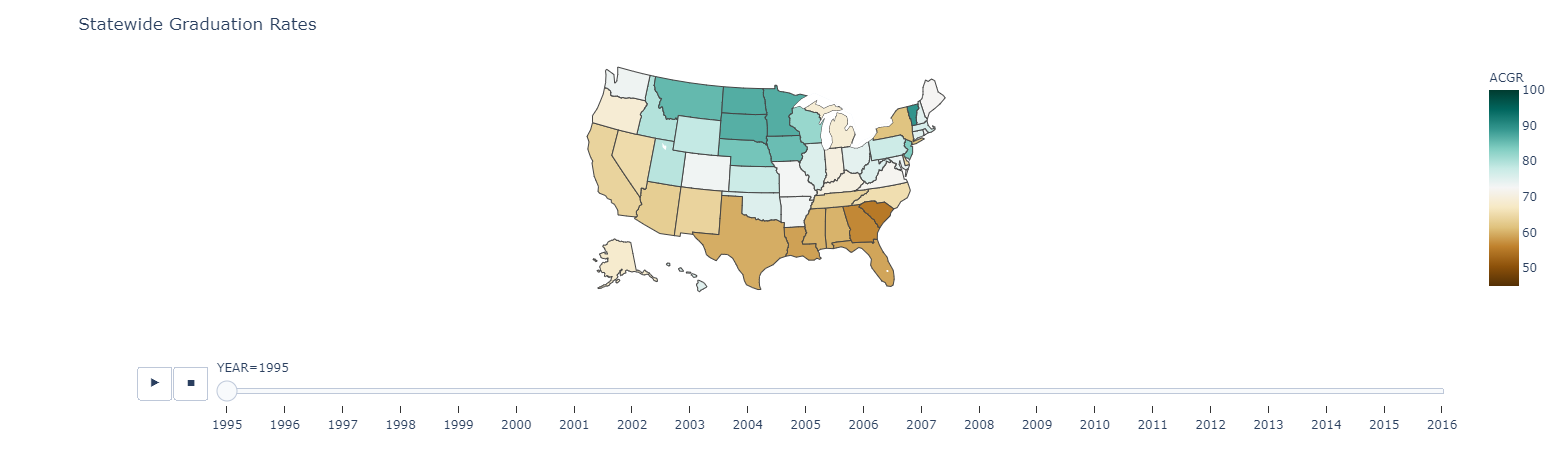

In [19]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# preparing plot data
plot_data = [state_grad[x].rename(columns={'grad_rate':'ACGR'}).reset_index() for x in range(len(state_grad))]
plot_data = pd.concat(plot_data)

# create plot
fig = px.choropleth(plot_data,  # Input Pandas DataFrame
                    locations='STATE',  # DataFrame column with locations
                    color='ACGR',  # DataFrame column with color values
#                     color_continuous_scale='Viridis',
#                     color_continuous_scale='Emrld_r',
                    color_continuous_scale=px.colors.diverging.BrBG,
                    animation_frame='YEAR',
                    range_color = (45,100),
                    hover_name='STATE', # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Statewide Graduation Rates', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
    dragmode=False,
)
    
fig.write_html("statewide_grad_rates.html")
fig.show()  

We create a similar map below for total expenditures per pupil. It appears that while there is an overall increase in funding, as there was for graduation rate, the funding changes are far less homogeneous, with sharp upticks in a few states such as New York and Wyoming while other states remain stagnant. While graduation rates have converged across country for the last 25 years, funding has diverged, thogh both have increased overall.

In [20]:
# preparing the plot data
plot_data = [data_by_year[x].reset_index() for x in range(len(data_by_year))]
plot_data = pd.concat(plot_data)

# create plot
fig = px.choropleth(plot_data,  # Input Pandas DataFrame
                    locations='STATE',  # DataFrame column with locations
                    color='TOTALEXP_pupil',  # DataFrame column with color values
#                     color_continuous_scale='Viridis',
                    color_continuous_scale='Emrld_r',
#                     color_continuous_scale=px.colors.diverging.BrBG,
                    animation_frame='YEAR',
                    labels = {'Exp':'Expenditures'},
                    range_color = (7400,28000),
                    hover_name='STATE', # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Total Expenditures per Pupil', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
    dragmode=False,
)

fig.write_html("exp_per_pupil.html")
fig.show()  

Below we define a function that may be used to create a detailed plot for the graduation rate and total expenditures per pupil for whichever state the reader chooses. Below we present the history of AL, WI, and NY. Note that we see sharp upticks in the graduation rates for NY and AL. Alabama's per pupil expenditures have increased steadily and significantly over this time, but not as sharply as New York's, which was already spending the among the most in the nation in 1995.

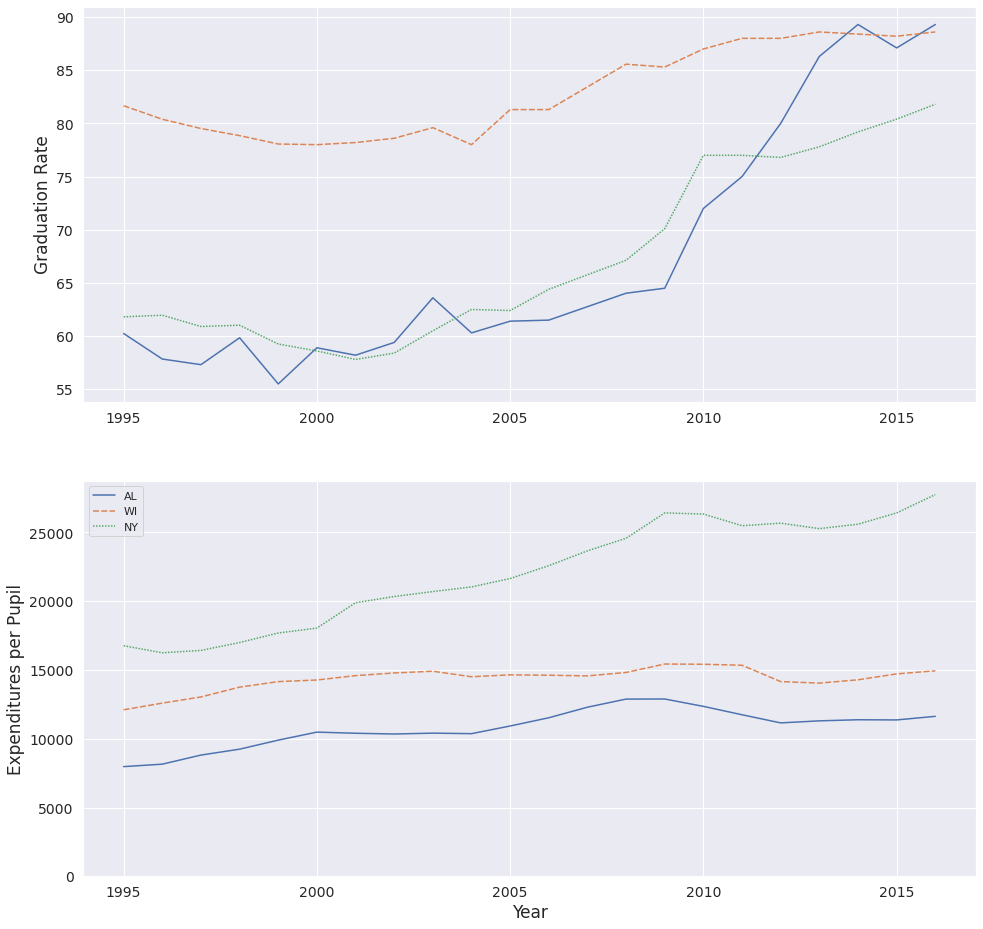

In [10]:
def plot_grad_rate(data,data_aux=[],states=['AL','WI']):
    # list of all the years for which we have data for the x axis of our plots
    years = np.arange(data[0].index[0][1],data[-1].index[0][1]+1)
    
    # prepare data for plot
    grad_data = {state: [data[x].loc[(state,years[x]),'grad_rate'] for x in range(len(data))] for state in states}
    if data_aux != []:
        grad_data_aux = {state: [data_aux[x].loc[(state,years[x]),'grad_rate'] for x in range(len(data))] for state in states}
    
    fund_data = {state: [data[x].loc[(state,years[x]),'TOTALEXP_pupil'] for x in range(len(data))] for state in states}
    
    # make plot
    fig, (ax1,ax2) = plt.subplots(2,1)
    
    sns.lineplot(data=pd.DataFrame(grad_data,years),ax=ax1,legend=False)
    ax1.set_ylabel('Graduation Rate')
    
    if data_aux != []:
        sns.lineplot(data=pd.DataFrame(grad_data_aux,years),ax=ax1,legend=False)
    sns.lineplot(data=pd.DataFrame(fund_data,years),ax=ax2)
    
    ax2.set_ylabel('Expenditures per Pupil')
    ax2.set_xlabel('Year')
    
    plt.ylim(bottom=0)
    plt.legend()
    
    plt.show()
    
plot_grad_rate(data=data_by_year,states=['AL','WI','NY'])

Finally, we investigate the degree of correlation between the ACGR and various overall funding numbers. Below is a scatterplot for ACGR vs. total expenditures per puil over the entire period from 1995 to 2016. The graph indicates an overall positive correlation, but is quite messy with a wide spread.

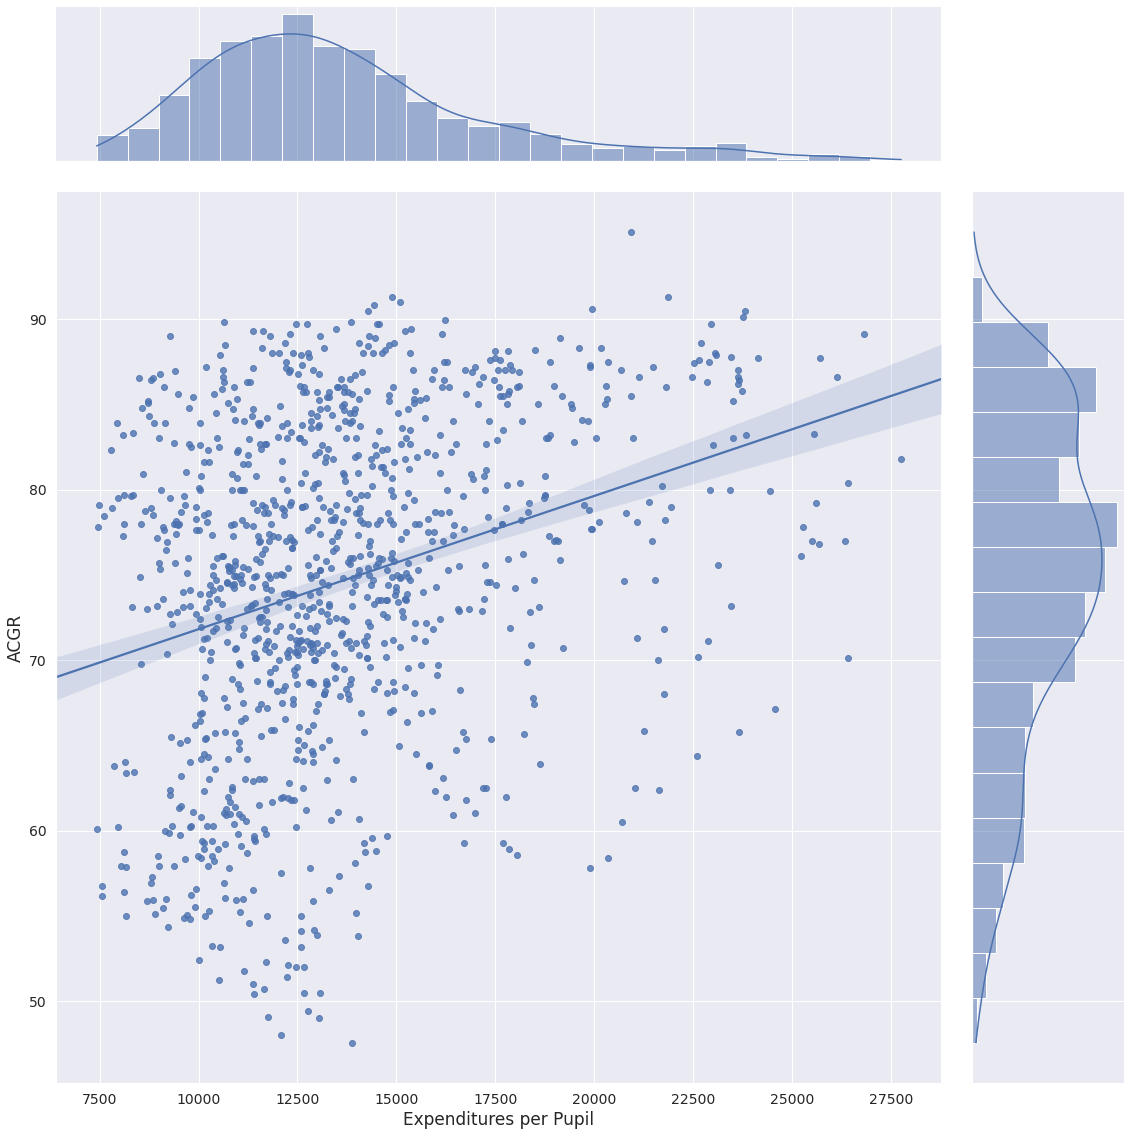

In [11]:
g = sns.jointplot(x="Expenditures per Pupil", y="ACGR",
                  data=pd.concat(data_by_year).rename(columns={'grad_rate':'ACGR','TOTALEXP_pupil':'Expenditures per Pupil'}),
                  kind="reg", truncate=False,
                  color="b", height=16)

The following graph roughly summarizes how these expenditures are prioritized throughout this period. Instruction takes up roughly half these numbers. Here 'support' expenditures are for both pupil and instructional support.

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Instruction'),
  Text(1, 0, 'Support'),
  Text(2, 0, 'Admin'),
  Text(3, 0, 'Other')])

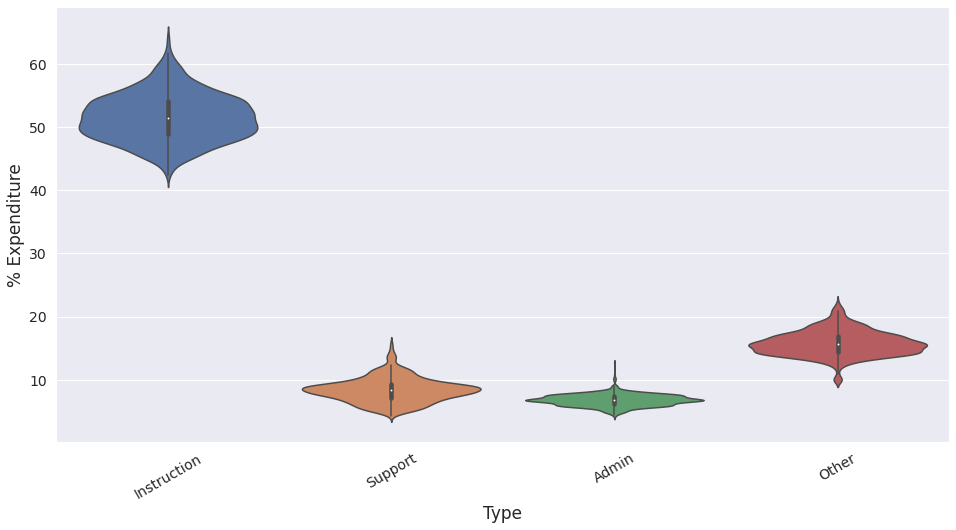

In [12]:
plot_data = pd.concat(data_by_year)

inst = pd.DataFrame({'% Expenditure':100*plot_data['E13_perc_exp']})
support_pup_inst = pd.DataFrame({'% Expenditure':100*(plot_data['E07_perc_exp']+plot_data['E17_perc_exp'])})
support_admin = pd.DataFrame({'% Expenditure':100*(plot_data['E08_perc_exp']+plot_data['E09_perc_exp'])})
other = pd.DataFrame({'% Expenditure':100*(plot_data['TCUROTH_perc_exp']+plot_data['V40_perc_exp']+plot_data['V45_perc_exp']+plot_data['V85_perc_exp'])})

inst['Type'] = ['Instruction']*len(inst)
support_pup_inst['Type'] = ['Support']*len(support_pup_inst)
support_admin['Type'] = ['Admin']*len(support_admin)
other['Type'] = ['Other']*len(other)

plot_data = pd.concat([inst,support_pup_inst,support_admin,other])

fig = plt.figure(figsize=(16,8))
g = sns.violinplot(data=plot_data, 
                x='Type',
                y='% Expenditure',
                scale='width')

plt.xticks(rotation=30)

Finally, let's take a look at how each of these sub-categories correlates with the ACGR. The data of course includes far more subdivided features and our hope is that by training a neural network we can find more sophisticated *causal* relationships amongst these variables by including this as well as training on the history of funding policy and graduation rates.

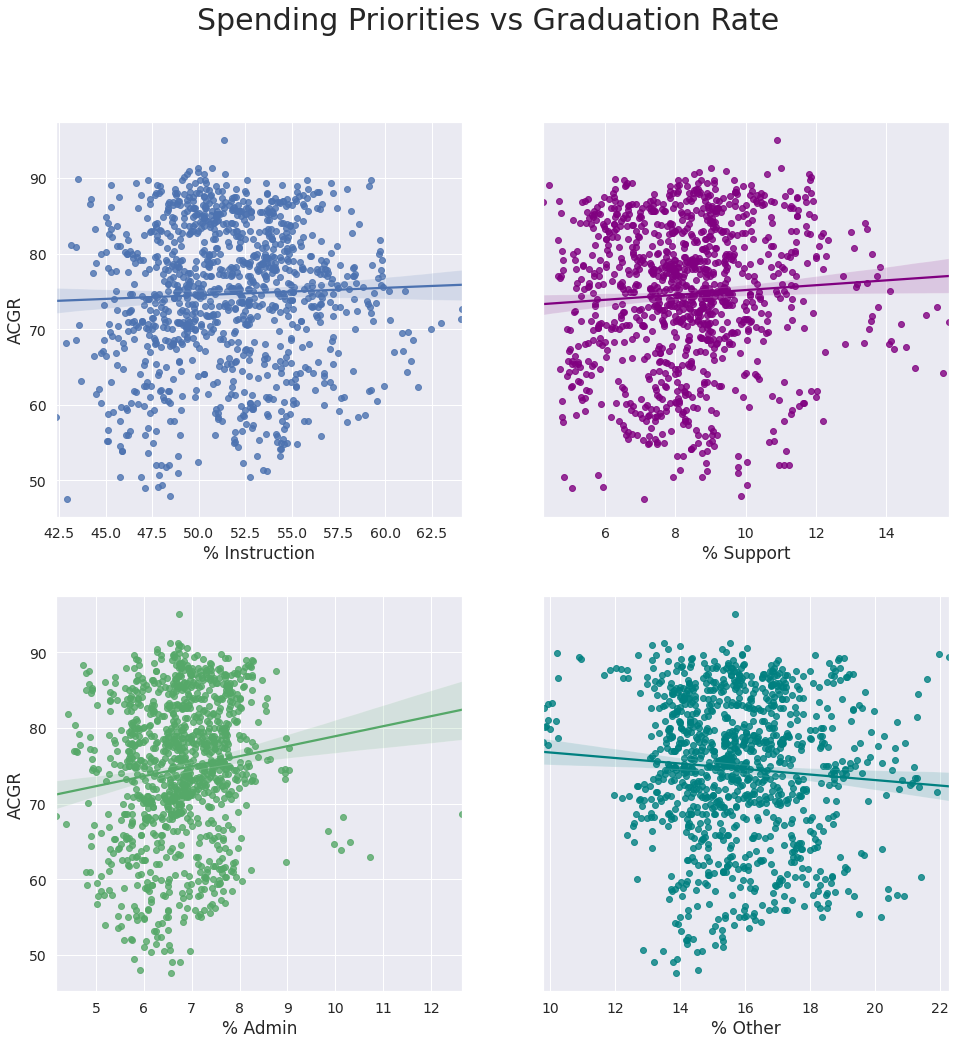

In [13]:
plot_data = pd.concat(data_by_year)

inst = pd.DataFrame({'% Instruction':100*plot_data['E13_perc_exp'],
                     'ACGR':pd.concat(data_by_year)['grad_rate']})
support_pup_inst = pd.DataFrame({'% Support':100*(plot_data['E07_perc_exp']+plot_data['E17_perc_exp']),
                     'ACGR':pd.concat(data_by_year)['grad_rate']})
support_admin = pd.DataFrame({'% Admin':100*(plot_data['E08_perc_exp']+plot_data['E09_perc_exp']),
                     'ACGR':pd.concat(data_by_year)['grad_rate']})
other = pd.DataFrame({'% Other':100*(plot_data['TCUROTH_perc_exp']+plot_data['V40_perc_exp']+plot_data['V45_perc_exp']+plot_data['V85_perc_exp']),
                     'ACGR':pd.concat(data_by_year)['grad_rate']})


fig, ax = plt.subplots(2,2)

fig.suptitle('Spending Priorities vs Graduation Rate',fontsize=30)

sns.regplot(x="% Instruction", y="ACGR",
                  data=inst,
                  ax=ax[0][0])

sns.regplot(x="% Support", y="ACGR",
                  data=support_pup_inst,
                  color = 'purple',
                  ax=ax[0][1])
ax[0][1].get_yaxis().set_visible(False)

sns.regplot(x="% Admin", y="ACGR",
                  data=support_admin,
                  color = 'g',
                  ax=ax[1][0])

sns.regplot(x="% Other", y="ACGR",
                  data=other,
                  color = 'teal',
                  ax=ax[1][1])
ax[1][1].get_yaxis().set_visible(False)

# Modeling the Graduation Rate

Finally, let's turn to creating and training a model for the ACGR using the data at hand. To get the most out of our data, in our training we will include not only the funding data of the year for which the prediction is being performed, but also the history of both graduation rate and funding up to that point. This has several advantages. First of all, this data has obvious importance in the real world - an instantaneous change in funding does not have an instantaneous effect on the schools in question. Second, it allows us to go beyond correlation and identify causal relationships. If there have been successful policy interventions having to do with funding over the 22 year history under consideration, the models should learn this. If we can in fact create an accurate model, then this past history of success or failure should be incorporated and help us to estimate the time-delayed effects of policy changes in the future.

We thus begin by defining a function within python to take the data at hand, and add the history, up to some number of years back, to the matrix of independent variables for the year being estimated. The function `add_history` takes four arguments:
* `data`: a list of dataframes, each element of the list corresponding to one year
* `length`: the number of years of funding history we wish to include
* `skip`: how often we wish to sample the data for this length of time. For instance, when `skip=1` we are taking every other year. Theoretically, this is to help the model look at longer term trends and prevent overfitting, though we will have to evaluate it's effect on performance in practice
* `end`: at what year we should cut off the data set. This will be used for evaluating model performance retrospectively and will be set to zero in the final model if successful.


Each row in our then contains financial data from its given year, plus chronologically ordered data from the previous `length+1` years. If the chronological data extends back prior to 1995, we will not include this, as this would introduce an artificial distinction amongst our data points that our model could use to learn, for example, how many years since 1995 it has been. As such, once the `add_history` function has been called our on our list of dataframes `data_by_year` of length 22, it will return a list of dataframes of length `22 - length`.

Note that there is an inherent tradeoff to increasing the value of `length`: each row contains more information, which can help our model learn chronological patterns, but there are fewer rows, which can negatively impact performance of the model. Below we show the models performance as evaluated by the MAE for different values of the parameter `length` to see which values are best. 

We can see this tradeoff quite clearly. At first, including the historical data helps: the MAE shows a clear downward trend, begining at 1.95 percentage points when no history is included, and sharply decreasing to 1.49 when `length=6`. Performance then oscillates for a few years until decreasing to a high of nearly 2.

There is then a sharp dropoff once we have `length=15`. This may seem counter-intuitive since the model is being fed very few training points at this stage and one might expect the performance to further degrade. We interet this sharp falloff as a type of 'overtraining': at this point, the model is only predicting graduation rates over a period of only 7 years or less and is likely detecting the overall significantly higher graduation rates of the 2010's as opposed to the 2000's or 1990's. This type of data, though it increases model performance, is not generalizeable to making predictions into the 2020s and beyond. At the end of the day, we choose to go with the model where `length=6`, both for its low MAE and for inclusion of chronological data without reducing the size of the dataset too much.



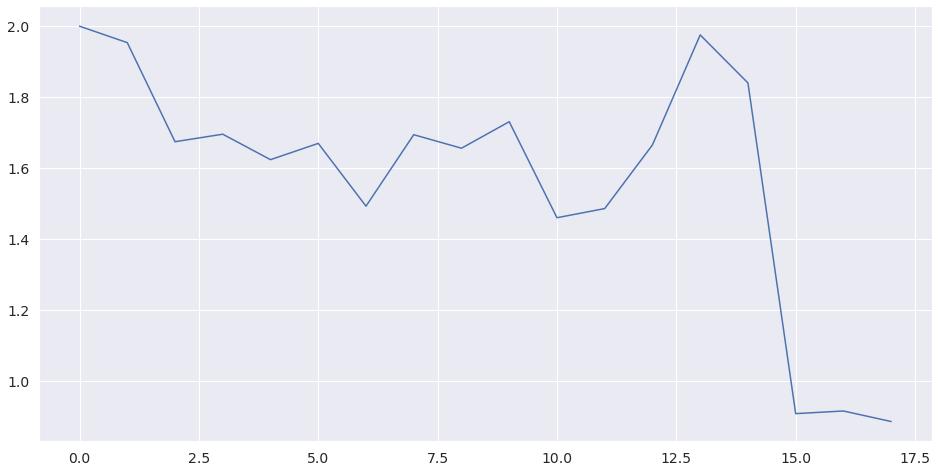

In [14]:
# lets create a function that can easily add history to our data, should we want it
# end is for later when attempt to evaluate the performance under time evolution
# is number of years chop off at the end
def add_history(data,end=0,length=5,skip=1):
    new_data = []
    years_back = np.arange(1,length+1,skip+1).tolist()
    
    for x in range(max(years_back),len(data)-end):
        hist_for_concat = [ data[x] ] + [ data[x-y].add_suffix('_-'+str(y)).set_index(data[x].index) for y in years_back ]
        new_data.append(pd.concat(hist_for_concat,axis=1))
        
    return new_data

# scores obtained with neural net with different history lengths considered
scores = {0:2.0,1: 1.9536778926849365, 2: 1.6745920181274414, 3: 1.6957530975341797, 4: 1.6240234375, 5: 1.6699272394180298, 6: 1.4930499792099, 7: 1.6943539381027222,8: 1.6562694311141968,9: 1.730919361114502,10: 1.4604758024215698,11: 1.4862796068191528,12: 1.6655384302139282,13: 1.9753928184509277,14: 1.840127944946289,15: 0.9086724519729614,16: 0.9161083698272705,17: 0.886421263217926}

# plot results
fig = plt.figure(figsize=figsize)
sns.lineplot(data=scores)
plt.show()

Finally, we train our neural network in the code below.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# train a model and see how it does at predicting current year's poverty state by state

# add history
end = 0
length = 6
skip = 0

data_by_year_hist = add_history(data_by_year,end=end,length=length,skip=skip)

# stack years into single dataframe for training the model
X = pd.concat(data_by_year_hist,axis=0)
y = X.pop('grad_rate')

# scaled data prefered for stochastic gradient descent
scaler = StandardScaler()
X = scaler.fit_transform(X)

# perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=random_state)

# now train a neural net
# for reproducibility
seed(random_state)
set_seed(random_state)

# create and train model
width = 512

model_net = keras.Sequential([
    layers.Dense(width, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(width, activation='relu'),
    layers.Dense(width, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(width, activation='relu'),
    layers.Dense(width, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model_net.compile(
    optimizer='adam',
    loss='mae',
)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model_net.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=1000,
    callbacks=[model_checkpoint_callback],
    verbose=0
)

model_net.load_weights(checkpoint_filepath)

y_pred = model_net.predict(X_test).flatten()

print('Best Neural Net Performance:')
print('\tMAE:',min(history.history['val_loss']))
print('\tsqrt-MSE:',np.std(y_pred-y_test))

Best Neural Net Performance:
	MAE: 1.5375856161117554
	sqrt-MSE: 2.3165913071862185


We can enhance the performance of our neural network with little additional effort through blending. Below we train a random forest on the data at hand. Performance is worse than the neural network of course, with an MAE of around 1.82. Below we train the random forest and additionally find the optimal parameter for blending. The resulting blended model has an MAE of about 1.42, improving on our neural network's performance of 1.49.

In [16]:
# create a random forest model to blend with the neural network

model_rf = RandomForestRegressor(n_estimators=100,
                              criterion='mae',
                              n_jobs=-1,
                              min_samples_leaf = 3,
                              random_state=random_state,
                              verbose=0)
model_rf.fit(X_train,y_train)

# make prediction
y_pred = model_rf.predict(X_test)

# display MAE and std deviation
print('RF Performance')
print('\tValidation MAE:',mean_absolute_error(y_pred,y_test))
print('\tValidation sqrt-MSE:',np.std(y_pred-y_test))
print()

# #------------------------------------------------------------------#
# #------------------------------------------------------------------#
# #------------------------------------------------------------------#

# blend the models for optimal performance

# produce blended data
xx = np.arange(0,1.01,0.01)
yy = []

for x in xx:
    y_pred = x * model_net.predict(X_test).flatten() + (1-x) * model_rf.predict(X_test).flatten()
    yy.append(mean_absolute_error(y_pred,y_test))
    
# plot it
# plt.plot(xx,yy)
# plt.show()

# extract best result
min_idx = yy.index(min(yy))
x_best = xx[min_idx]
y_best = yy[min_idx]
(xx[min_idx],yy[min_idx])

print('Blended model performance:')
print('\t(x,MAE)=',(x_best,y_best))

RF Performance
	Validation MAE: 1.8201717187500006
	Validation sqrt-MSE: 2.7926498233600414

Blended model performance:
	(x,MAE)= (0.68, 1.4272499336830147)


# Seeing the Future

We have a model then that predicts a given years ACGR with excellent performance, missing the true graduation rate in our validation data by an average of merely 1.4 percentage points. We would like to use this model to predict the result of funding policy after its been in place for a given number of years. We can do this easily enoug by running the model iteratively, feeding it the funding policy we are considering each successive year. Since we have trained the model on real funding history, it will take into account not only the funding policy put in place, but the status of that states educational funding and success rate before-hand. 

If we wish to do so however, we need to re-evaluate the performance of our model, seeing how well it performs predictions multiple years into the future on real data. This is what we focus on in this section. We will take the validation data given above and remove the most recent years of graduation data, and then use our model to predict the graduation rates for those years on the actual historical funding data. We then compare back to the actual graduation rates and evaluate how our model did using the MAE.

We perform this in the code below. To prevent data leakage here we retrain the model using only the data up to the point at which we have decided to start our retrospective simulation.

In [17]:
# make a prediciton on given data using the optimized parameters for the blended model founded above
def predict(X_input):
    return x_best * model_net.predict(X_input).flatten() + (1-x_best) * model_rf.predict(X_input).flatten()

def predict_retro(X_input):
    return x_best_retro * model_net_retro.predict(X_input).flatten() + (1-x_best_retro) * model_rf_retro.predict(X_input).flatten()
    
# years is number of years that you want to retroactively predict
def retro_evolve(years):
    # create local copy of the data
    data_loc = [ df.copy() for df in data_by_year ]
    
    # for storing how well the model does each year
    scores = dict()
        
    # now go year by year and replace the grad_rate data
    # by generating the historical data and then predicting
    for x in range(years+1):
        data_loc_hist = add_history(data_loc,end=years-x,length=length,skip=skip)
        if -years+x == 0:
            data_loc_hist = add_history(data_loc,length=length,skip=skip)
        
        # stack years into single dataframe for prediction and scale
        X_loc = data_loc_hist[-1].drop(columns=['grad_rate'])
        X_loc = scaler.transform(X_loc)
        
        # make our prediction
        data_loc[-years-1+x]['grad_rate'] = predict_retro(X_loc)
        scores[x] = mean_absolute_error(predict_retro(X_loc),data_by_year[-years-1+x]['grad_rate'])
        
        # need both validation scores and overall!
        # this is mismatch, scores is MAE on all of the data
        
    return (data_loc,scores)
    
# truncate the data and evaluate performance
end = 8
length = 6
skip = 0

data_by_year_hist = add_history(data_by_year,end=end,length=length,skip=skip)

# stack years into single dataframe for training the model
X = pd.concat(data_by_year_hist,axis=0)
y = X.pop('grad_rate')

# scaled data prefered for stochastic gradient descent
X = scaler.transform(X)

# perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=random_state)

# for reproducibility
seed(random_state)
set_seed(random_state)

# fit the models on the truncated data
width = 512

model_net_retro = keras.Sequential([
    layers.Dense(width, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(width, activation='relu'),
    layers.Dense(width, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(width, activation='relu'),
    layers.Dense(width, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model_net_retro.compile(
    optimizer='adam',
    loss='mae',
)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model_net_retro.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=1000,
    callbacks=[model_checkpoint_callback],
    verbose=0
)

model_net_retro.load_weights(checkpoint_filepath)


model_rf_retro = RandomForestRegressor(n_estimators=100,
                              criterion='mae',
                              n_jobs=-1,
                              min_samples_leaf = 3,
                              random_state=random_state,
                              verbose=0)
model_rf_retro.fit(X_train,y_train)

# blend the models for optimal performance
# produce blended data
xx = np.arange(0,1.01,0.01)
yy = []
for x in xx:
    y_pred = x * model_net_retro.predict(X_test).flatten() + (1-x) * model_rf_retro.predict(X_test).flatten()
    yy.append(mean_absolute_error(y_pred,y_test))

# extract best result
min_idx = yy.index(min(yy))
x_best_retro = xx[min_idx]

The performance of simulation results over 8 years are pictured below. We see that model performance starts pretty good, with an MAE of about 0.9 for predicting the current years graduation rate, however performance degrades rapidly. Performing predictions 3 years out the simulation quickly devolves into unuseable territory with average errors in excess of 8 points.

Our main take away from this is that over the long term, factors other than funding and previous graduation rates are much more important. It's easy to think of possible outside influences: overall economic conditions, soft factors like student and teacher happiness, etc.

At the end of the day, though our model is relatively accurate predicting the current year, on time scales greater than a few years, model performance is exceedingly poor, and should not be trusted.

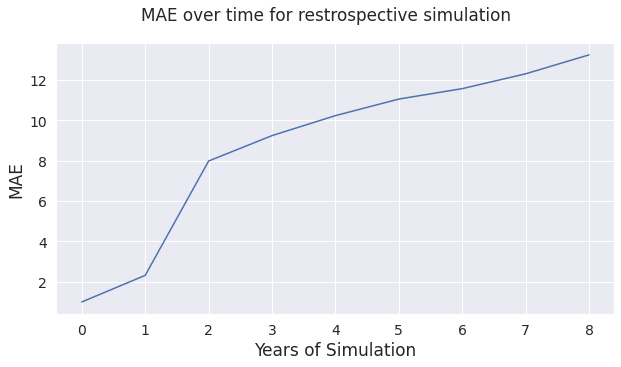

In [18]:
retro_data, scores = retro_evolve(years=end)

# plot results
fig = plt.figure(figsize=(10,5))
plt.suptitle('MAE over time for restrospective simulation')
plt.xlabel('Years of Simulation')
plt.ylabel('MAE')
sns.lineplot(data=scores)
plt.show()